# Severity Modelling

This covers the second part of the modelling. The target variable is the loss.

## 001: Create the dataset and split dataset

In [15]:
from model import feature
from src.model.dataset import Dataset

insurance_initiation_variables_path = "../data/input/exp/Insurance_Initiation_Variables.csv"
claims_variables_path = "../data/input/exp/sample_type_claim.csv"

claim_grouping_columns = ['ID', 'Cost_claims_year']
claim_aggregation_column = 'Cost_claims_by_type'
merging_columns = ['ID', 'Cost_claims_year']

dataset = (Dataset(data_path=insurance_initiation_variables_path,
                   claims_path=claims_variables_path)
           .group_claims(grouping_columns=claim_grouping_columns, aggregation_column=claim_aggregation_column)
           .create_dataset(merge_columns=merging_columns)
           )
trainset, testset = dataset.split_dataset(test_ratio=0.2, to_shuffle=False)

## 002: Engineer relevant features

In [16]:
from model.feature import main as feature_main

features_trainset = feature_main(trainset)
features_testset = feature_main(testset)

## 003: Severity modelling

The response variable is the number of claims dubbed `Cost_claims_year` in the dataset. The first step would be to understand the distribution of the response variable

Average loss distribution: 149.84895492871016


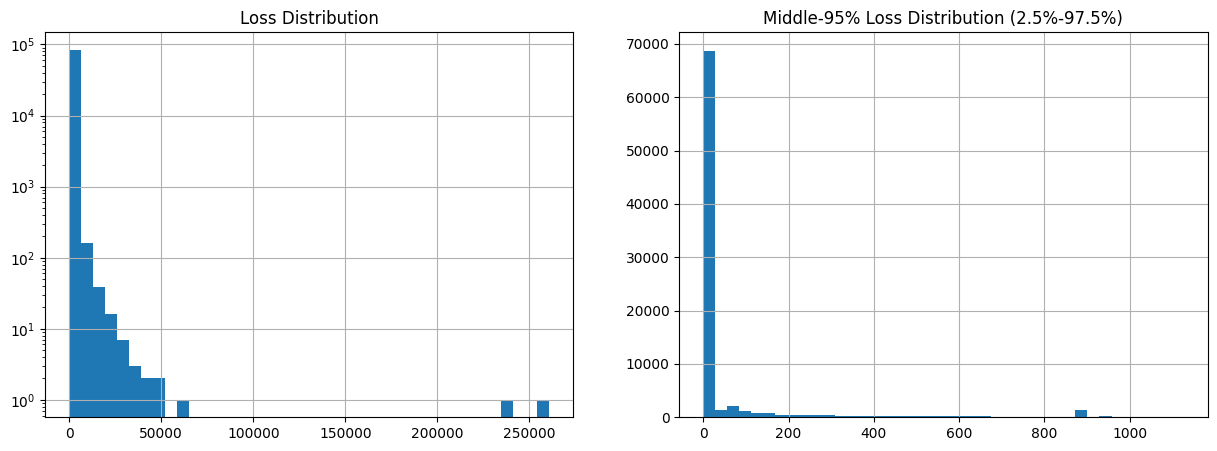

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))
ax0.set_title('Loss Distribution')
_ = features_trainset['Cost_claims_year'].hist(bins=40, log=True, ax=ax0)

p2_5, p97_5 = np.percentile(features_trainset['Cost_claims_year'], [2.5, 97.5])
middle_95 = features_trainset['Cost_claims_year'][(features_trainset['Cost_claims_year'] >= p2_5) &
                                                   (features_trainset['Cost_claims_year'] <= p97_5)]
ax1.set_title('Middle-95% Loss Distribution (2.5%-97.5%)')
_ = middle_95.hist(bins=40, log=False, ax=ax1)

print(
    "Average loss distribution: {}".format(
        np.average(features_trainset['Cost_claims_year'])
    )
)

Then we follow the steps have below to fit the model
- Define evaluation metrics
- Filter for policies with claims severity greater than 0 because gamma distribution support positive values greater than 0
- We fit a dummy model and a gamma model and compare both
- We review the observed vs predicted for the test set

In [18]:
training_variables = ['Car_age_years', 'Type_risk', 'Area', 'Value_vehicle', 'Distribution_channel',
                      'Cylinder_capacity']
target = ['Cost_claims_year']

In [19]:
from sklearn.metrics import mean_absolute_error,mean_poisson_deviance,mean_squared_error

def model_evaluation_metrics(estimator, df_test, target_variable=target, training_variables=training_variables):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test[training_variables])

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test[target], y_pred,
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test[target], y_pred
        )
    )


In [20]:
train_mask = features_trainset['Cost_claims_year']>0
updated_features_trainset = features_trainset[train_mask]
test_mask = features_testset['Cost_claims_year']>0
updated_features_testset = features_testset[test_mask]

#### Model 1 - Baseline Model, Just predicting the mean

In [21]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
dummy_regressor = dummy.fit(updated_features_trainset[training_variables], updated_features_trainset[target])

#### Model 2: Gamma Regressor

In [22]:
from sklearn.linear_model import GammaRegressor
gamma = GammaRegressor(alpha=10, solver="newton-cholesky")
gamma_regressor =  gamma.fit(updated_features_trainset[training_variables], updated_features_trainset[target].values.ravel())

## 004: Severity Modelling Evaluation

In [23]:
for idx, model in enumerate([dummy_regressor, gamma_regressor]):
    print(f"Now evaluating model {str(model)}")
    print(f"Model metrics : {model_evaluation_metrics(estimator=model, df_test=updated_features_testset, target_variable=target,)}")
    print("-------------")

Now evaluating model DummyRegressor()
MSE: 9493940.052
MAE: 889.053
Model metrics : None
-------------
Now evaluating model GammaRegressor(alpha=10, solver='newton-cholesky')
MSE: 9476204.283
MAE: 888.685
Model metrics : None
-------------


In [26]:
def plot_obs_pred(
    df,
    feature,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature]].copy()
    df_["observed"] = df[observed] #* df[weight]
    df_["predicted"] = predicted #* df[weight]
    df_ = (
        df_.groupby([feature])[[ "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"])
        .assign(predicted=lambda x: x["predicted"])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max, #* df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

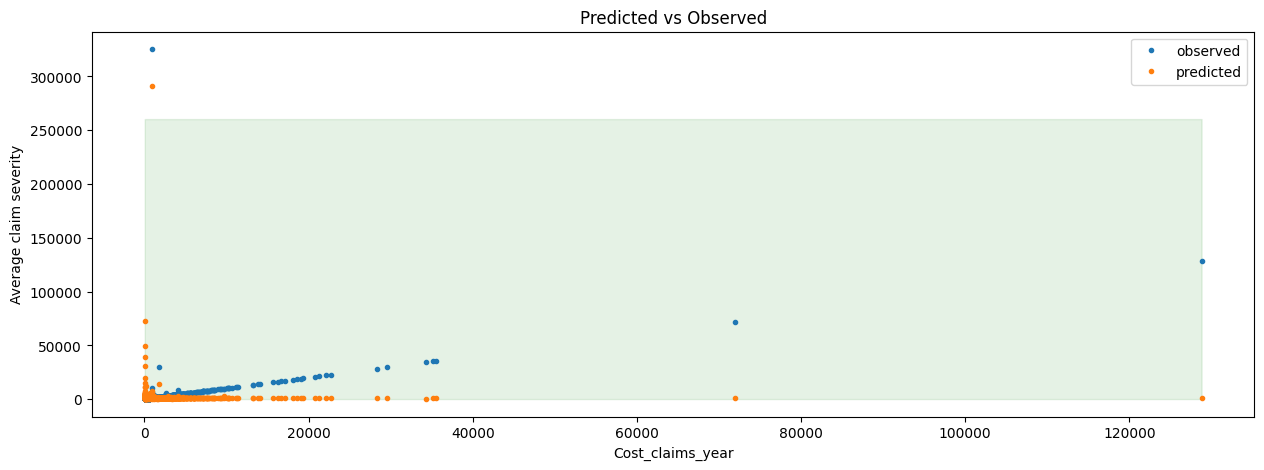

In [32]:
feature_col = target[0]

fig, ax = plt.subplots(ncols=1, figsize=(15, 5))

plot_obs_pred(
    df=updated_features_testset,
    feature=feature_col,
    observed=feature_col,
    predicted=gamma_regressor.predict(updated_features_testset[training_variables]),
    y_label="Average claim severity",
    title="Predicted vs Observed",
    ax=ax
)